# Project 3: SSD Performance Profiling

## Setup

Disk:

 MODEL        TRAN   SIZE

sda Virtual Disk      388.4M

sdb Virtual Disk        186M

sdc Virtual Disk          4G

sdd Virtual Disk          1T

CPU: AMD Ryzen 5 7600X 6-Core Processor

OS: Ubuntu 24.04.3 LTS(WSL2)

filesystem: sda (ext4, 1.0), sdb (ext4, 1.0), sdc (swap) sdd (ext4, 1.0) = 911.6G

fio --direct=1

## Result

### 3.1 Zero-queue baselines

we prepares a 10 GB test file and runs fio benchmarks with four workloads. The results are saved to separate log files. To avoid interference from the operating system cache, direct I/O mode was enabled. The workloads included 4 KiB random reads and writes as well as 128 KiB sequential reads and writes, each executed for thirty seconds on a 10 GB test file.

run:

In [ ]:
bash fio_results.sh

| Pattern       | Avg_Latency_us | p95_us | p99_us | Bandwidth (MiB/s) | IOPS |
| ------------- | -------------- | ------ | ------ | ----------------- | ---- |
| 4K_RandRead   | 185.51         | 227    | 326    | 21.0              | 5366 |
| 4K_RandWrite  | 243.55         | 285    | 441    | 16.0              | 4088 |
| 128K_SeqRead  | 131.94         | 169    | 302    | 944               | 7551 |
| 128K_SeqWrite | 297.24         | 343    | 506    | 419               | 3348 |


The zero-queue baseline results show clear contrasts between random and sequential workloads. For 4 KiB operations, random reads reached 5366 IOPS with an average latency of 185.5 µs, while random writes were slower at 4088 IOPS and 243.6 µs. The higher write latency reflects extra overhead from device-level operations, and the tail latencies (p95/p99) confirm greater variability for writes.

In comparison, 128 KiB sequential workloads delivered much higher throughput. Sequential reads achieved 944 MiB/s with stable latency (avg 131.9 µs, p99 302 µs), while sequential writes reached 419 MiB/s but with higher latency (avg 297.2 µs, p99 506 µs). This gap highlights the relative efficiency of large contiguous reads versus the overhead of large writes.

These baselines confirm that small-block random I/O is latency-bound, sequential access provides significantly higher bandwidth, and writes consistently incur higher cost than reads.

### 3.2 Block-size & pattern sweep

 A fixed 10 GB test file is accessed with random and sequential read/write patterns across block sizes from 4 KB to 256 KB. Each run is configured with direct I/O, queue depth 1, a single job, a 30-second runtime, and a 5-second ramp time. The results are saved as JSON files for plotting. 

 run: 

In [ ]:
bash task2_random.bash

bash task2_seq.bash

python3 plot_2_read.py

python3 plot_2_write.py

|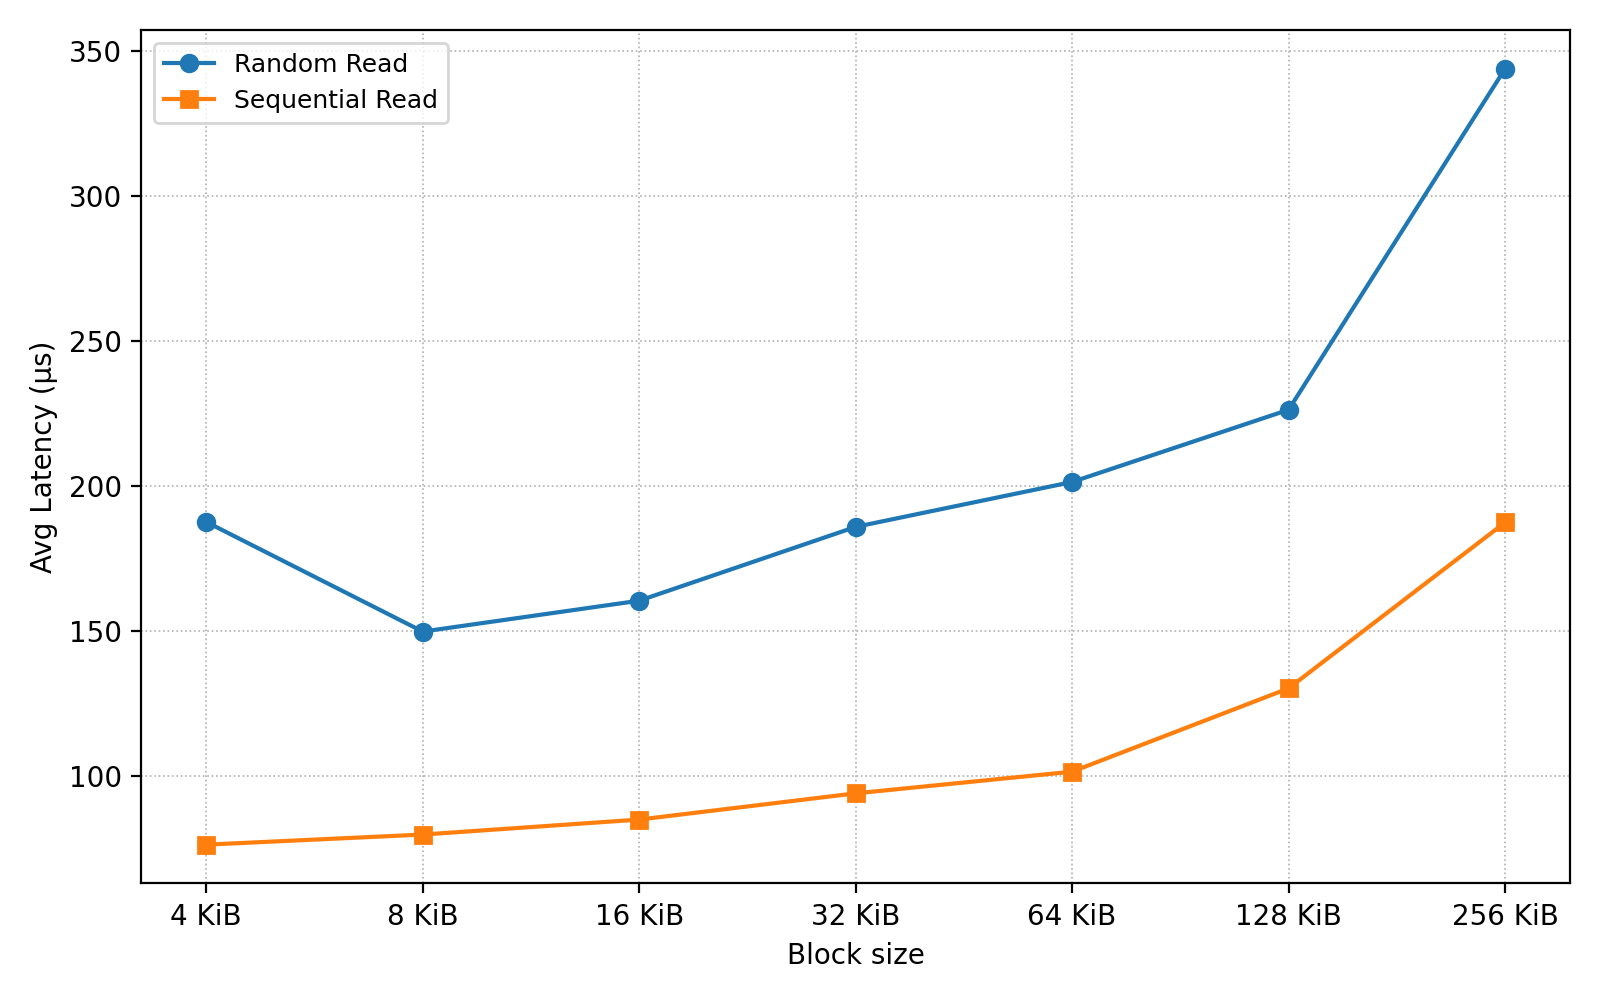| 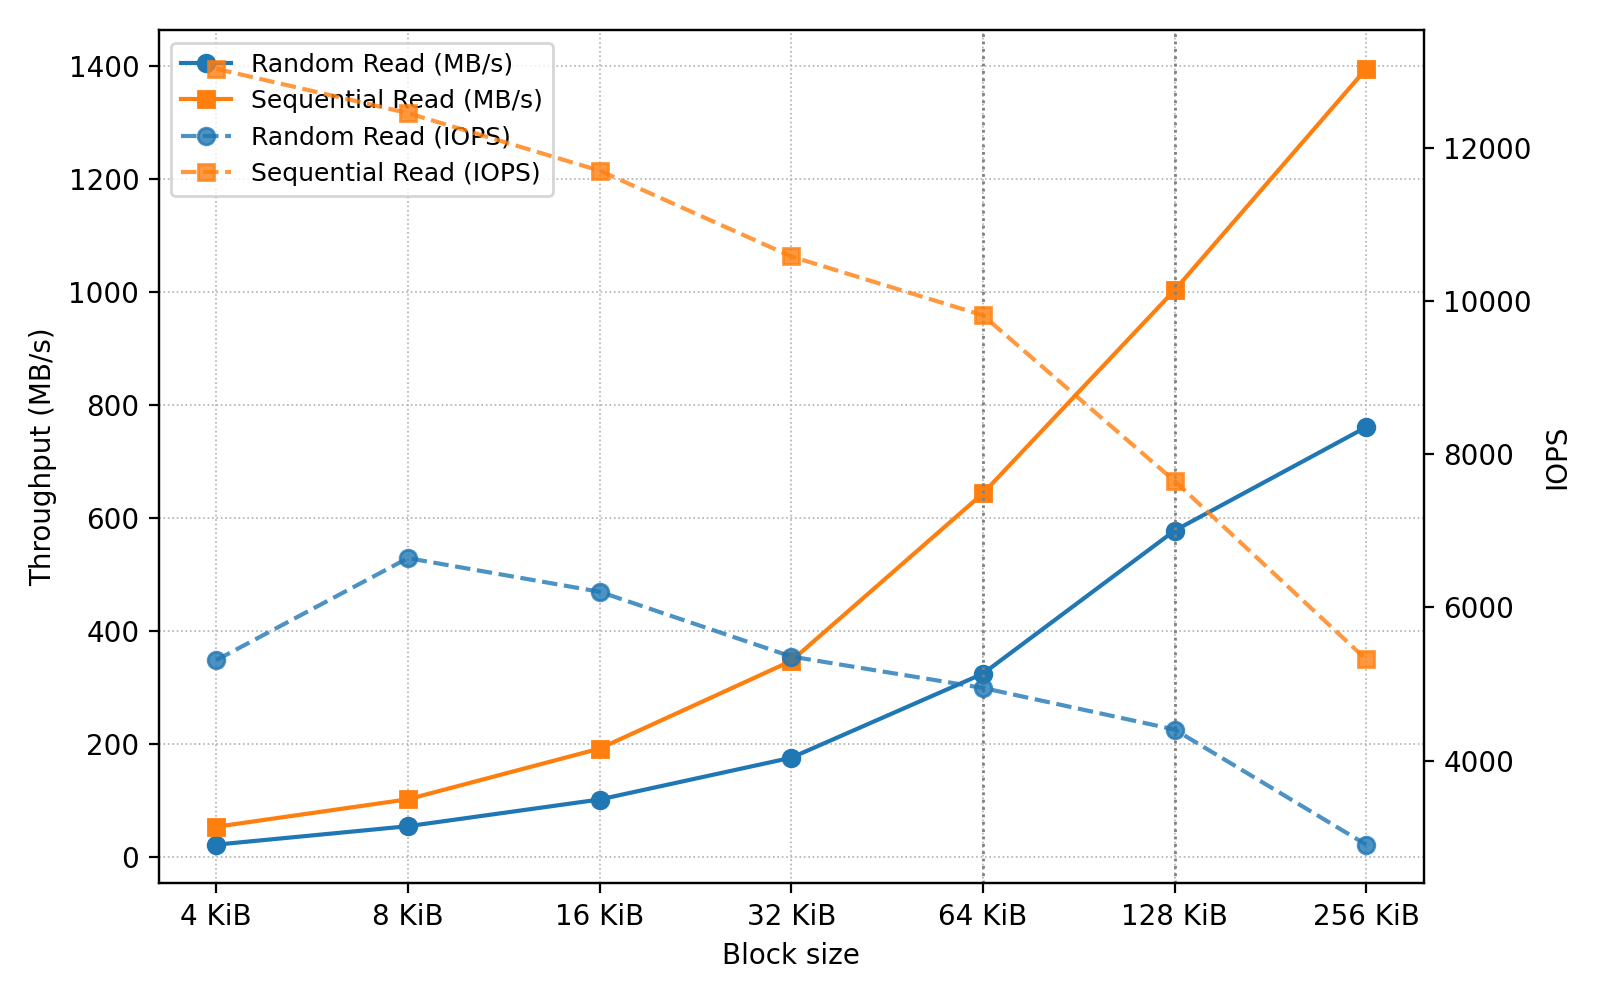|
|:----------------------------------------------------:|:----------------------------------:|

The results show clear differences between random and sequential read performance as block size increases. For small blocks (4–32 KiB), throughput is dominated by IOPS, with random reads achieving only modest bandwidth and higher average latency compared to sequential reads. Sequential reads, however, benefit from prefetching and queue coalescing in the controller, which efficiently merges adjacent requests and drives much higher throughput. As the block size grows beyond 64 KiB, the curves demonstrate a crossover from IOPS-dominated to bandwidth-dominated regimes: IOPS declines, but MB/s rises steadily, particularly for sequential access where prefetching allows bandwidth to scale almost linearly until controller or interface limits are approached. Latency also grows with block size, since each I/O operation covers more data, but the increase is much more pronounced in random access where controller optimization is less effective.

|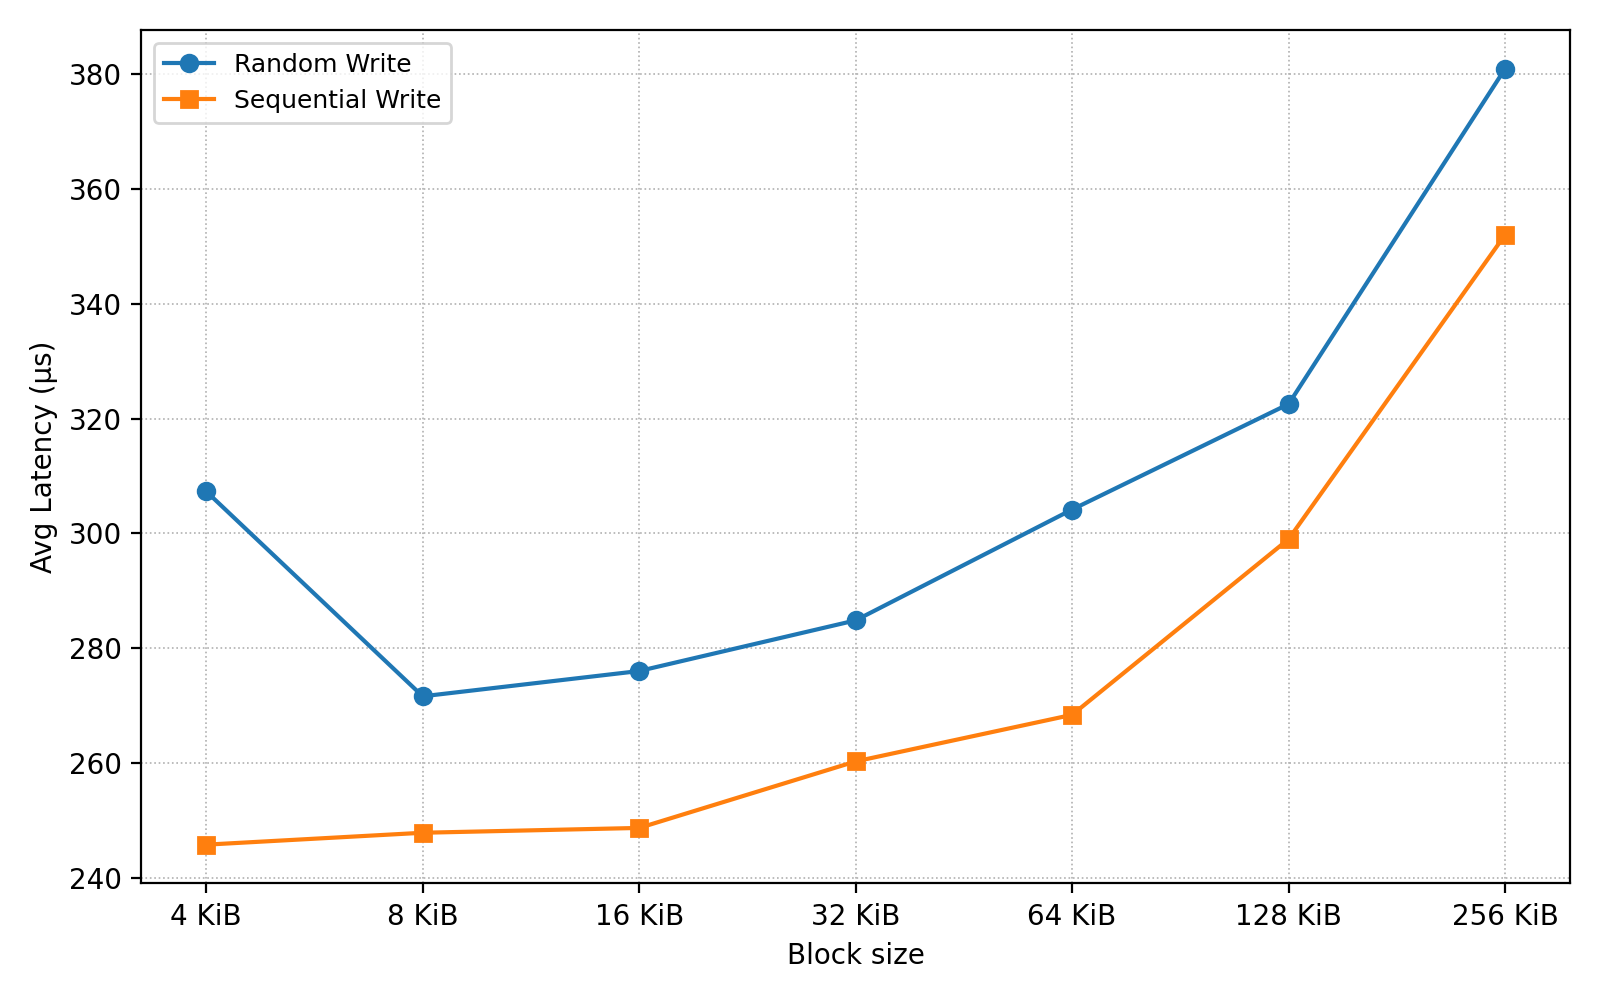| 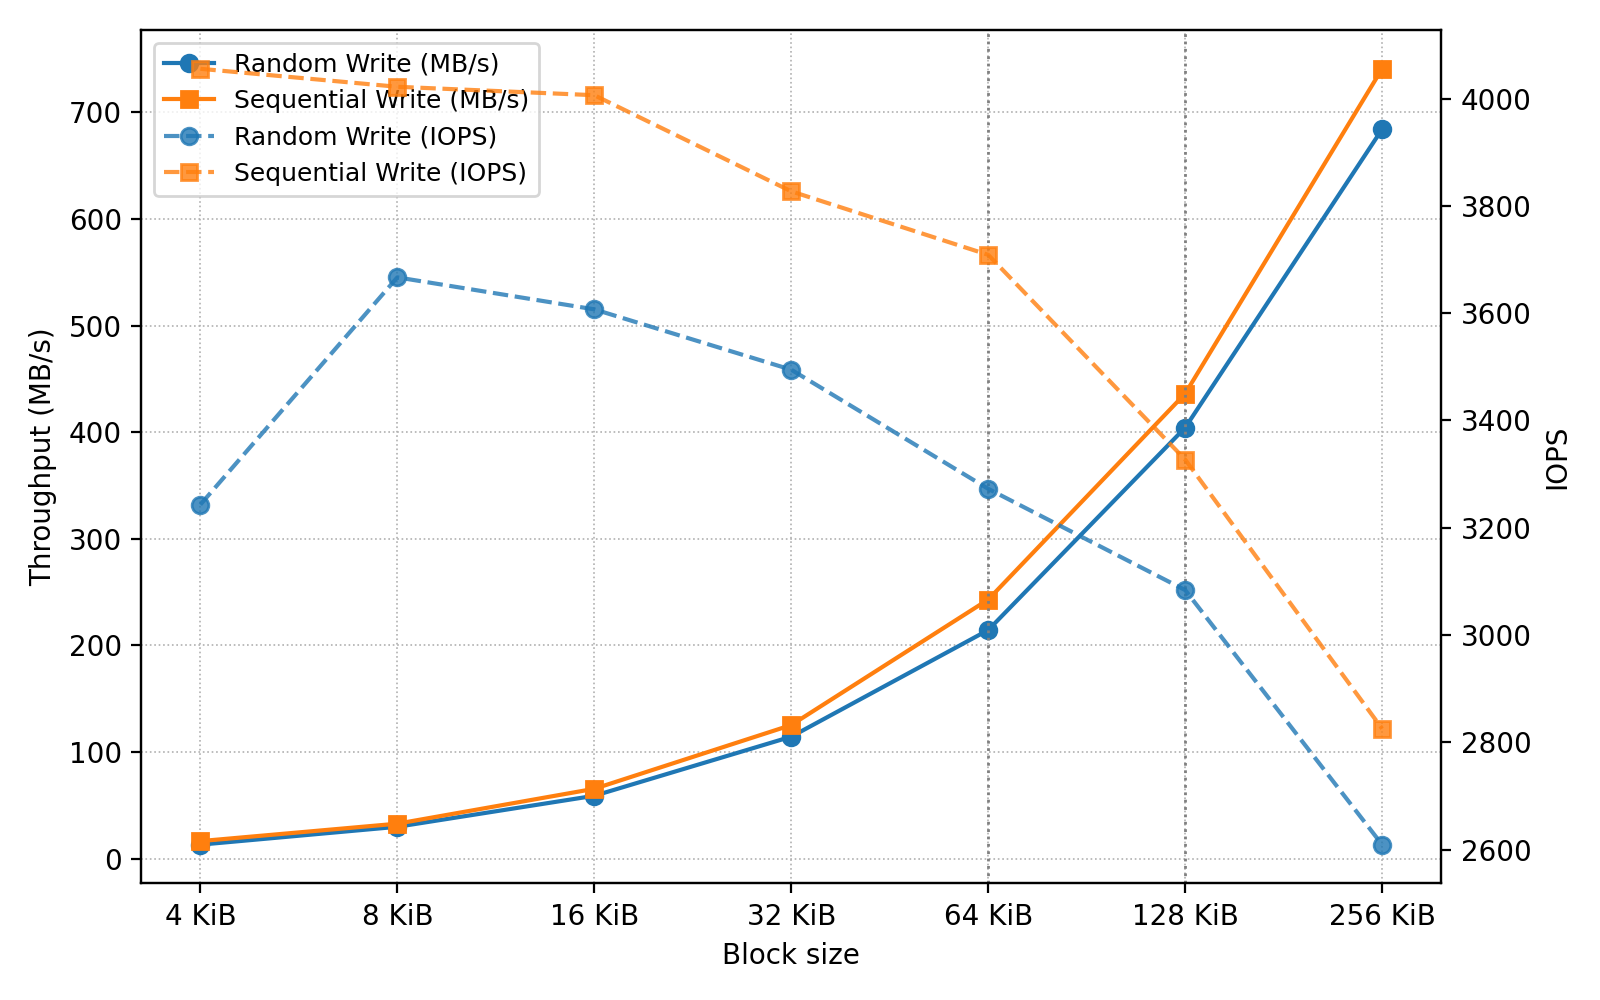|
|:----------------------------------------------------:|:----------------------------------:|

The write benchmarks show that sequential and random patterns behave differently as block size increases. At small blocks (4–16 KiB), random writes suffer from higher average latency, while sequential writes maintain lower latency due to controller-level write coalescing and buffering. As block size grows, both random and sequential writes experience rising latency, but the increase is more pronounced in random writes because each large operation amplifies the effect of address translation and flash program overhead. On the throughput side, sequential writes scale almost linearly with block size, reaching more than 700 MB/s at 256 KiB, maybe benefiting from prefetching and queue coalescing. Random writes bandwidth remains lower and their IOPS drops sharply after 32 KiB, showing the inefficiency of handling large random operations. The crossover from IOPS-dominated to bandwidth-dominated regimes again appears between 64–128 KiB, where throughput growth comes primarily from larger transfer sizes rather than more operations per second. These results highlight that sequential writes align well with the device’s internal optimizations, while random writes remain constrained by higher latency and reduced efficiency as block size increases.

### 3.3 Read/Write mix sweep

we difine the target test file path and then loops over four ratios of read operations: 100, 70, 50, and 0. For each ratio, it runs fio with the job name reflecting the mix. The workload type is set to random read/write (randrw). Each test uses a 4 KB block size, a queue depth of one (iodepth=1), and a single job thread. The file size is fixed at 10 GB, the test runs for 30 seconds in time-based mode with a 5-second ramp-up period to stabilize performance. Direct I/O is enabled to bypass the operating system cache. Each run saves its performance metrics in a separate JSON file.

run:

In [ ]:
bash task3.bash

python3 plot_3.py

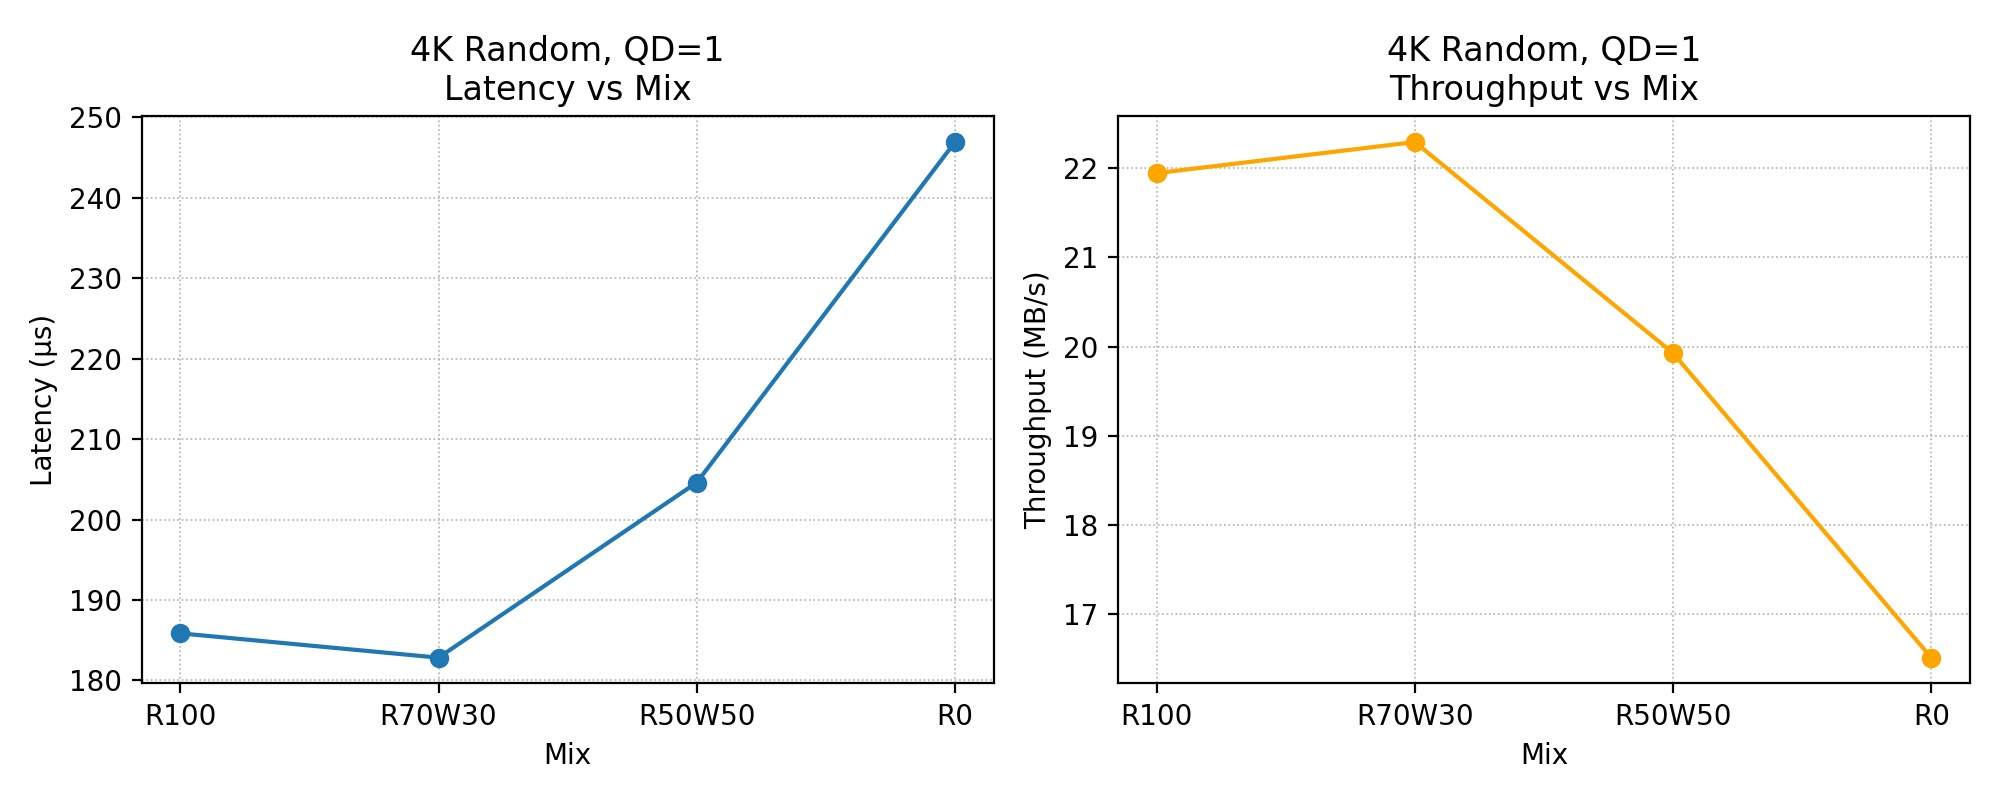

 On the latency plot, pure reads (R100) and read-dominant mixes (R70W30) achieve the lowest latencies (≈185 µs), because reads are typically served more efficiently, and SSD controllers can prefetch or coalesce them effectively. As the write ratio increases (R50W50, R0), latency rises sharply, reaching nearly 250 µs for pure writes. This might be the overhead of write amplification (WA), the need to maintain flash page alignment, and internal flush operations that force the SSD controller to commit data, all of which add delay.

On the throughput plot, read-heavy mixes (R100, R70W30) achieve the highest bandwidth (≈22 MB/s), while mixed workloads see a drop, and pure writes (R0) fall to the lowest throughput (≈16 MB/s). The performance gap again reflects the cost of buffering and flushing writes: random writes disrupt sequential programming in NAND, forcing the controller to allocate new pages and perform garbage collection.

### 3.4 Read/Write mix sweep

The outer loop iterates over queue depths (iodepth) of 1, 2, 4, 8, 16, and 32, while the inner loop repeats each configuration three times to account for performance variation. For each run, fio executes a 4 KB random read workload (--rw=randread, --bs=4k) with a dq and the chosen jobs. The workload is time-based, running for 30 seconds after a 5-second ramp-up period, with direct I/O enabled to bypass the operating system cache. The results of each run are stored in JSON files. We also add error bar in the figure.

run:

In [ ]:
bash task4.sh

python3 plot_4.py

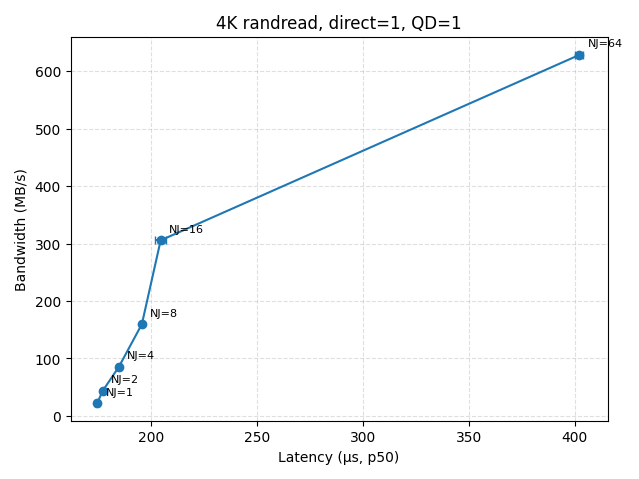

The throughput-latency curve shows that as the effective queue depth increases from 1 to 64, IOPS increases almost linearly, while latency also increases. This behavior is expected according to Little's Law, as throughput is proportional to concurrency and average latency. 

The curve's knee occurs around Q≈16, where throughput reaches approximately 75k IOPS and median latency is approximately 210 µs. Beyond this point (for example, when Q=64), IOPS continues to increase to around 150k IOPS, but latency doubles to nearly 400 µs, indicating system saturation. Therefore, the knee is NJ≈16 according to Little’s Law. 

Since this machine is a virtual disk, we compare this to the vendor specifications of a typical PCIe Gen3 NVMe SSD (which typically advertises 500k-800k IOPS for 4K random reads). The measured peak of 150k IOPS only represents approximately 30% of the rated performance. This discrepancy can be attributed to factors such as insufficient queue depth, software and driver overhead, and fio configuration limitations. Overall, while concurrency provides clear benefits, further increasing concurrency yields diminishing returns as the latency penalty outweighs the throughput gain.

### 3.5 Tail-latency characterization

I choose job = 16(knee) and job = 8 when doing 4KB randread.

| job  | p50    | p95    | p99    | p99.9   |
|-----|--------|--------|--------|---------|
| 8   | 195.58 | 257.02 | 291.50 | 362.50  |
| 16  | 204.46 | 272.38 | 310.61 | 396.63  |

When analyzing tail latency for 4KB random reads at job = 8 and job = 16 (the knee), we observe that while the median latency remains around 200 µs, the p99.9 latency nearly doubles, showing that a small fraction of requests suffer from significantly longer delays due to queueing. As the queue depth increases, both the average and the tail latencies grow, reflecting the impact of saturation where additional requests must wait in the queue. This means that even though mean performance may appear acceptable, the presence of high p99 and p99.9 latencies can violate SLA requirements in latency-sensitive systems, causing noticeable stalls for end users. Therefore, operating near or beyond the knee point can lead to disproportionate tail latency penalties, and in practice, maintaining a moderate queue depth such as 8 provides a better trade-off between throughput and SLA compliance.

### 3.6 Limitations

Host-side factors such as OS scheduling noise, page cache effects, and CPU contention may interfere with fio’s measurements, especially when multiple jobs are used to emulate parallelism. Additionally, the relatively short runtime of each test may not fully capture steady-state behavior, making transient caching effects more pronounced. Furthermore, all experiments were conducted under WSL2 rather than on bare-metal Linux, which introduces an extra virtualization and translation layer for disk I/O between the Linux guest and the Windows host filesystem. This layer can add variability, obscure true device-level performance, and limit the accuracy of tail-latency characterization. Some of the anomalies like sudden throughput drops or irregular tail-latency growth are likely due to device-level background activity, host-side interference, and the additional virtualization overhead of WSL2 rather than workload design alone.